# SmartlabThermal Wrapper notebook example

In this example,  we demonstrate the use of wrappers around an Energym environment to create new environments that are more suitable for control.

In [1]:
from energym.examples.Controller import LabController

Next, we import Energym and create the simulation environment by specifying the model, a weather file and the number of simulation days.

In [2]:
import energym

weather = "ESP_CT_Barcelona"
env = energym.make("SmartlabThermal-v0", weather=weather, simulation_days=300)

C:\Users\PSh\AppData\Local\Continuum\anaconda3\envs\Opti\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


[OK] fmi2Instantiate: The Resource location of FMU with instance name %s is %s.

[WARNING] fmi2Instantiate: Argument loggingOn is set to %d
. This is not supported. loggingOn will default to '0'.

[OK] The current working directory is %s

[OK] fmi2Instantiate: Path to fmuUnzipLocation is not %s.

[OK] fmi2Instantiate: Path to fmuUnzipLocation is not %s.

[OK] fmi2Instantiate: Path to fmuUnzipLocation is not %s.

[OK] fmi2Instantiate: Path to fmuUnzipLocation %s

[OK] fmi2Instantiate: Path to fmuResourceLocation %s

[OK] Command executes to copy content of resources folder: %s

[OK] fmi2Instantiate: Path to model description file is %s.

[OK] fmi2Instantiate: The FMU modelIdentifier is %s.

[OK] fmi2Instantiate: The FMU modelGUID is %s.

[OK] fmi2Instantiate: Slave %s is instantiated.

[OK] fmi2Instantiate: Instantiation of %s succeded.

[OK] fmi2EnterInitializationMode: The sockfd is %d.

[OK] fmi2EnterInitializationMode: The port number is %d.

[OK] fmi2EnterInitializationMode: This h

The control inputs can be inspected using the `get_inputs_names()` method and to construct a controller, we pass the list of inputs and further parameters. This controller determines inputs to get close to the temperature setpoints and uses fixed setpoints during the night.

In [3]:
inputs = env.get_inputs_names()
print(inputs)
controller = LabController(control_list=inputs, lower_tol=0.3, upper_tol=0.8, nighttime_setback=True, nighttime_start=18, nighttime_end=6, nighttime_temp=18)

['Bd_Ch_EV1Bat_sp', 'Bd_Ch_EV2Bat_sp', 'Bd_Pw_Bat_sp', 'P1_T_Thermostat_sp', 'P1_onoff_HP_sp', 'P2_T_Thermostat_sp', 'P2_onoff_HP_sp', 'P3_T_Thermostat_sp', 'P3_onoff_HP_sp', 'P4_T_Thermostat_sp', 'P4_onoff_HP_sp']


The default environment has 480 steps per day, which may be too much for MPC controllers. It is possible to reduce the number of steps per day, adding custom operations (averaging, taking last value) for every variable, as demonstrated below

In [4]:
#Import the wrappers
from energym.wrappers.downsample_outputs import DonwsampleOutputs
from energym.wrappers.rescale_outputs import RescaleOutputs
from energym.wrappers.rescale_inputs import RescaleInputs
from energym.wrappers.rl_wrapper import RLWrapper


In [5]:
#Create an easy downsampling dictionary function
#Here we will always average over the values we got for all variables. Not that this is not necessarily what we want for all variables
# but it is convenient as an example

import numpy as np
steps = 5
downsampling_dic = {}
for key in env.get_outputs_names():
    downsampling_dic[key] = np.mean
    

#We also create an easy reward function, here only lookging at the first room tmp
def reward(outputs:dict):
    value = (outputs['Z01_T'] -0.5)**2
    return value

lower_bound = {'Ext_T':0.0}
upper_bound = {'Ext_T':30.0}

In [6]:
#We create a two layer wrapper. We both downsample and add rewards computation
env_down = DonwsampleOutputs(env, steps, downsampling_dic)
env_down_res = RescaleOutputs(env_down,lower_bound, upper_bound) #By default, the variables are rescaled between 0 and 1
env_down_res = RescaleInputs(env_down_res) #By defaults, the variables are rescaled between 0 and 1
#env_down_RL = RLWrapper(env_down_res, reward)  #Always put RLwrapper at the end

In [7]:
outputs = env_down_res.get_output()

In [8]:
outputs

OrderedDict([('Bd_Ch_EV1Bat_sp_out', 0.0),
             ('Bd_Ch_EV2Bat_sp_out', 0.0),
             ('Bd_DisCh_EV1Bat', 0.0),
             ('Bd_DisCh_EV2Bat', 0.0),
             ('Bd_FracCh_Bat', 0.0),
             ('Bd_FracCh_EV1Bat', 1.0),
             ('Bd_FracCh_EV2Bat', 1.0),
             ('Bd_Frac_Vent_sp_out', 0.5),
             ('Bd_Pw_Bat_sp_out', 0.5),
             ('Ext_Irr', 0.0),
             ('Ext_P', 0.45),
             ('Ext_RH', 0.9175),
             ('Ext_T', 0.17033333333333334),
             ('Fa_ECh_Bat', 0.0),
             ('Fa_ECh_EV1Bat', 0.0),
             ('Fa_ECh_EV2Bat', 0.0),
             ('Fa_EDCh_Bat', 0.0),
             ('Fa_EDCh_EV1Bat', 0.0),
             ('Fa_EDCh_EV2Bat', 0.0),
             ('Fa_E_All', 0.1000471177542633),
             ('Fa_E_Appl', 0.1131809208741962),
             ('Fa_E_Light', 0.0),
             ('Fa_E_self', 0.5050023558877133),
             ('Fa_Pw_All', 0.09444029038095234),
             ('Fa_Pw_HVAC', 0.0047834591690476165),


In [9]:
steps = 96*1
out_list = []
rew_list = []
outputs = env_down_res.get_output()
controls = []
hour = 0
for i in range(steps):
    control = controller.get_control(env_down_res.revert_outputs(outputs), 21, hour)
    control['Bd_Ch_EV1Bat_sp'] = [0.0]
    control['Bd_Ch_EV2Bat_sp'] = [0.0]
    controls +=[ {p:control[p][0] for p in control} ]
    outputs = env_down_res.step(env_down_res.revert_inputs(control))
    _,hour,_,_ = env_down_res.get_date()
    out_list.append(outputs)

In [10]:
#Revert values for checks
env_down_res.revert_inputs(control)

{'P1_T_Thermostat_sp': [0.25],
 'P2_T_Thermostat_sp': [0.15],
 'P3_T_Thermostat_sp': [0.15],
 'P4_T_Thermostat_sp': [0.2],
 'P1_onoff_HP_sp': [1.0],
 'P2_onoff_HP_sp': [1.0],
 'P3_onoff_HP_sp': [1.0],
 'P4_onoff_HP_sp': [1.0],
 'Bd_Ch_EV1Bat_sp': [0.0],
 'Bd_Ch_EV2Bat_sp': [0.0]}

In [11]:
env_down_res.revert_outputs(outputs)

{'Bd_Ch_EV1Bat_sp_out': 0.0,
 'Bd_Ch_EV2Bat_sp_out': 0.0,
 'Bd_DisCh_EV1Bat': 0.0,
 'Bd_DisCh_EV2Bat': 0.0,
 'Bd_FracCh_Bat': 0.0,
 'Bd_FracCh_EV1Bat': 0.7928119731492107,
 'Bd_FracCh_EV2Bat': 1.0,
 'Bd_Frac_Vent_sp_out': 0.5,
 'Bd_Pw_Bat_sp_out': 0.0,
 'Ext_Irr': 0.0,
 'Ext_P': 102500.0,
 'Ext_RH': 93.0,
 'Ext_T': 5.066000000000001,
 'Fa_ECh_Bat': 0.0,
 'Fa_ECh_EV1Bat': 0.0,
 'Fa_ECh_EV2Bat': 0.0,
 'Fa_EDCh_Bat': 0.0,
 'Fa_EDCh_EV1Bat': 0.0,
 'Fa_EDCh_EV2Bat': 0.0,
 'Fa_E_All': 190.81477531682117,
 'Fa_E_Appl': 56.5904604370981,
 'Fa_E_Light': 0.0,
 'Fa_E_self': 190.81477531681958,
 'Fa_Pw_All': 3572.1273885880314,
 'Fa_Pw_HVAC': 134.22431487972304,
 'Fa_Pw_Prod': 0.0,
 'Fa_Stat_EV1': 0.0,
 'Fa_Stat_EV2': 0.0,
 'P1_FlFrac_HW': 0.0,
 'P1_T_Tank': 49.26768542827109,
 'P1_T_Thermostat_sp_out': 18.5,
 'P1_onoff_HP_sp_out': 1.0,
 'P2_FlFrac_HW': 0.0,
 'P2_T_Tank': 47.87708786916473,
 'P2_T_Thermostat_sp_out': 17.5,
 'P2_onoff_HP_sp_out': 1.0,
 'P3_FlFrac_HW': 0.0,
 'P3_T_Tank': 49.99993297

In [12]:
env_down_res.get_forecast()

{'Ext_T': [0.1976021660508091,
  0.2034599377716829,
  0.20931770949255668,
  0.21517548121343044],
 'Ext_Irr': [0.0, 0.0, 0.0, 0.0],
 'Bd_DisCh_EV1Bat': [0.0, 0.0, 0.0, 0.0],
 'Bd_DisCh_EV2Bat': [0.0, 0.0, 0.0, 0.0]}

Since the inputs and outputs are given as dictionaries and are collected in lists, we can simply load them as a pandas.DataFrame.

In [13]:
import pandas as pd
out_df = pd.DataFrame(out_list)

To generate plots, we can directly get the data from the DataFrames, by using the key names. Displayed are the zone temperatures and the setpoints determined by the controller for zone 1 as well as the corresponding heat pump on/off switching, the external temperature, and the total power demand.

<IPython.core.display.Javascript object>


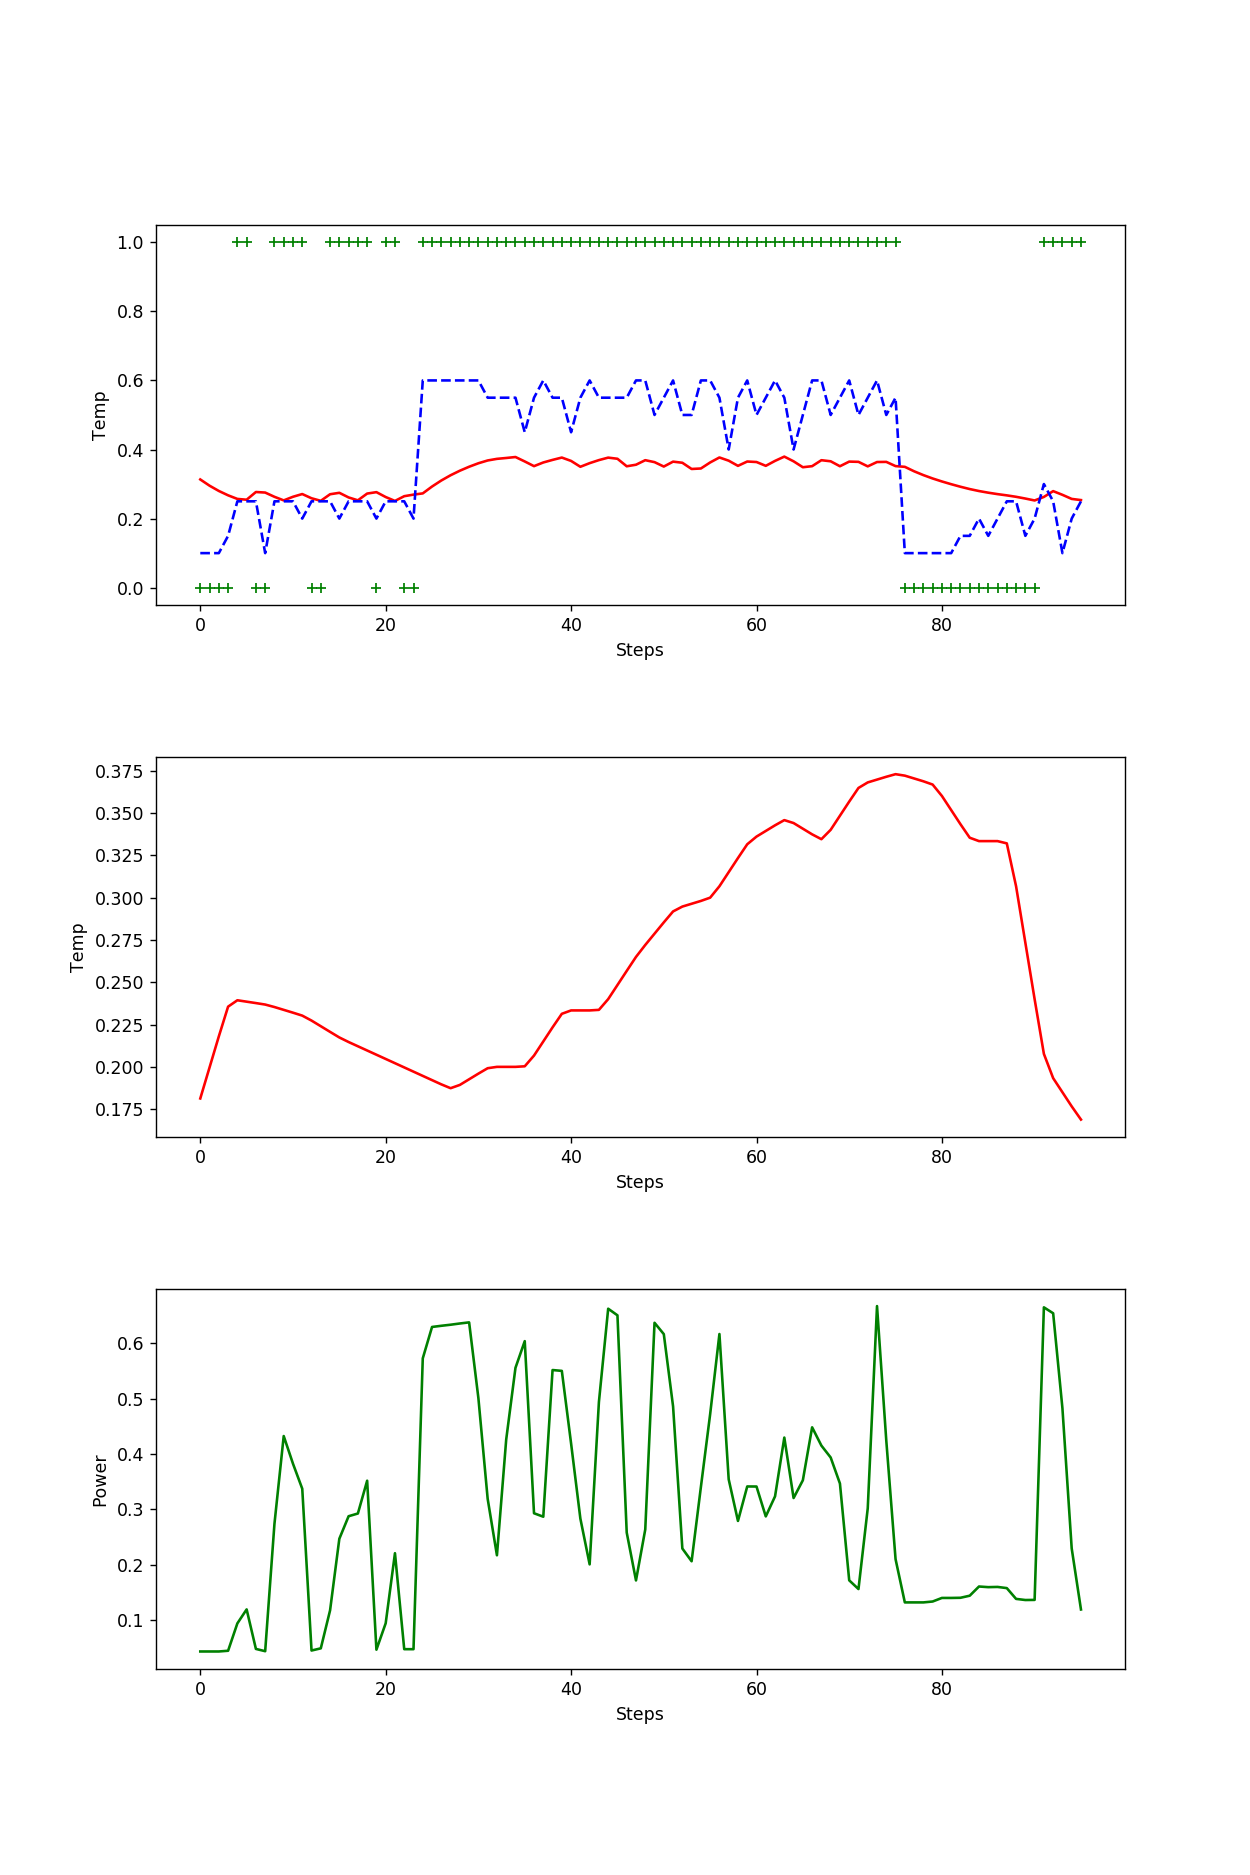

In [14]:
import matplotlib.pyplot as plt
%matplotlib notebook

f, (ax1,ax2,ax3) = plt.subplots(3,figsize=(10,15))#


ax1.plot(out_df['Z01_T'], 'r')
ax1.plot(out_df['P1_T_Thermostat_sp_out'], 'b--')
ax1.plot(out_df['P1_onoff_HP_sp_out'], 'g+' )
ax1.set_ylabel('Temp')
ax1.set_xlabel('Steps')

ax2.plot(out_df['Ext_T'], 'r')
ax2.set_ylabel('Temp')
ax2.set_xlabel('Steps')

ax3.plot(out_df['Fa_Pw_All'], 'g')
ax3.set_ylabel('Power')
ax3.set_xlabel('Steps')

plt.subplots_adjust(hspace=0.4)

plt.show()

To end the simulation, the `close()` method is called. It deletes files that were produced during the simulation and stores some information about the simulation in the *runs* folder.

In [15]:
env.close()

[OK] fmi2Terminate: fmiFreeInstanceSlave must be called to free the FMU instance.

[OK] fmi2FreeInstance: The function fmi2FreeInstance of instance %s is executed.

[OK] freeInstanceResources: %s will be freed.

